In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import warnings
warnings.filterwarnings("ignore")


import math
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.snowball import SnowballStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
os.chdir('./drive/My Drive/amazon_food_reviews')

In [0]:
sql = sqlite3.connect('database.sqlite')
raw_data = pd.read_sql_query(""" SELECT * FROM Reviews """, sql)


In [5]:
raw_data.shape

(568454, 10)

In [6]:
raw_data[raw_data["Score"]==3].values.shape

(42640, 10)

In [7]:
#filtering all data and rejecting the entries with score 3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", sql)

#function to label the score, if 4 or 5 score is positive else negetive
def partition(s):
  if s>3:
     return 1
  return 0

filtered_data['Score'] = filtered_data['Score'].map(partition)
filtered_data.head(3)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [8]:
filtered_data.shape

(50000, 10)

## Exploratory Data Analysis

### 1) Distribution of the different scores

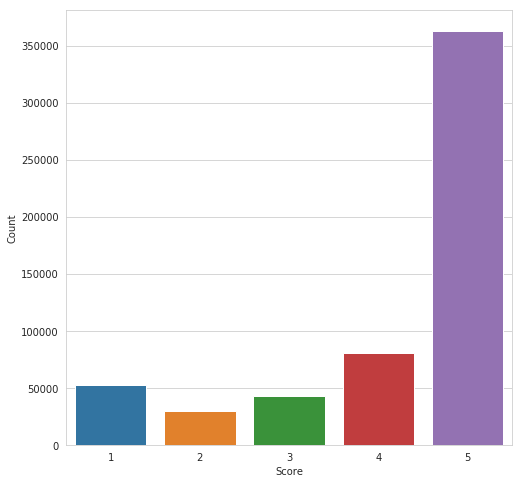

In [9]:
score_count = pd.read_sql_query(""" SELECT Score,count(*) FROM Reviews group by Score""", sql)

plt.figure(figsize = (8, 8)) 
sns.set_style("whitegrid");
sns.barplot(x=score_count["Score"],y=score_count["count(*)"])
plt.ylabel("Count")
plt.show();

**Observation:**

Most of the reviewers rated positively, the number of reviews getting a score of 5 is very high.

### 2) Scores and Helpfulness

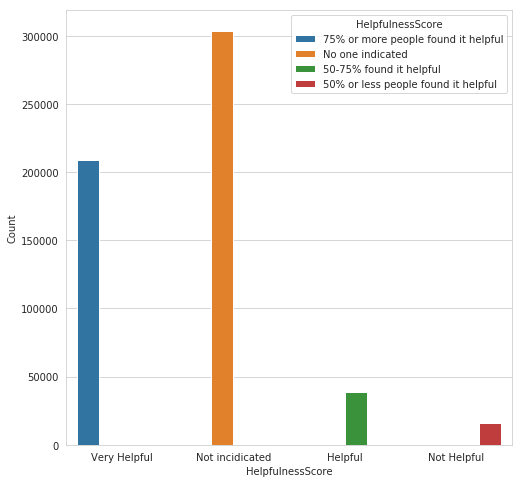

In [10]:
raw_data["HelpfulnessScore"] = raw_data["HelpfulnessNumerator"]/raw_data["HelpfulnessDenominator"]

def intervals(s):

  if s==0 or math.isnan(s):
    return "Not incidicated"
  elif s >= 0.75:
    return "Very Helpful"
  elif s>=0.5 and s<0.75:
    return "Helpful"
  else:
    return "Not Helpful"

raw_data["HelpfulnessScore"] = raw_data["HelpfulnessScore"].map(intervals)
Intervals = np.unique(raw_data["HelpfulnessScore"])
helpful_count = raw_data.groupby(["HelpfulnessScore"]).agg(['count'])["Id"]
helpful_count["count"] = helpful_count["count"]/len(raw_data) *100
plt.figure(figsize = (8, 8)) 
g = sns.countplot(x=raw_data["HelpfulnessScore"], hue=raw_data["HelpfulnessScore"])
plt.ylabel("Count")
plt.legend(title='HelpfulnessScore', labels=['75% or more people found it helpful', 'No one indicated', '50-75% found it helpful', '50% or less people found it helpful'])
plt.show(g)

**Observation:**

Most of the reviews(more than 50%) had no indication. While mostly the reviews which had indication were found to be very helpful that is more than 75% people who voted found it helpful. 

In [11]:
Intervals

array(['Helpful', 'Not Helpful', 'Not incidicated', 'Very Helpful'],
      dtype=object)

In [0]:
def ishelpful(s):

  if s=='Helpful' or s=='Very Helpful':
    return "Helpful"
  elif s == 'Not Helpful':
    return "Not Helpful"


isHelpful = pd.DataFrame(raw_data["HelpfulnessScore"].map(ishelpful))
isHelpful["Score"] = raw_data["Score"]

In [0]:
isHelpful.dropna(inplace = True)

In [14]:
isHelpful.head()

,HelpfulnessScore,Score
0,Helpful,5
2,Helpful,4
3,Helpful,2
8,Helpful,5
10,Helpful,5


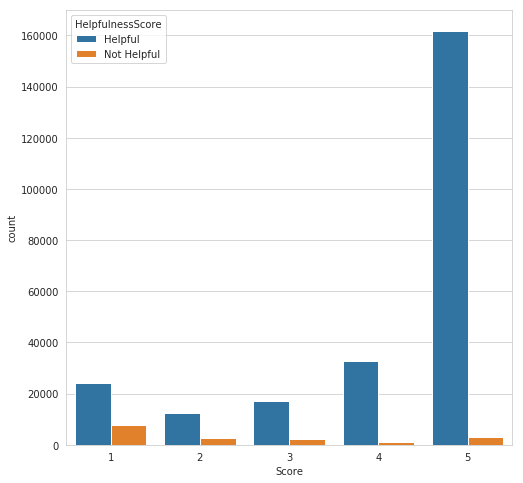

In [15]:
plt.figure(figsize = (8, 8)) 
g = sns.countplot(x=isHelpful["Score"], hue=isHelpful["HelpfulnessScore"] )#,estimator=lambda x: len(x) / len(isHelpful) * 100)
plt.show(g)

## **Data Cleaning**

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
where Score != 3
GROUP BY UserId
HAVING COUNT(*)>1
""", sql)

In [17]:
display.head()

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [18]:
display.shape

(75346, 7)

In [19]:
pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text
FROM Reviews
where Score != 3 and UserId = '#oc-R11D9D7SHXIJB9'

""", sql)

,UserId,ProductId,ProfileName,Time,Score,Text
0,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u..."
1,#oc-R11D9D7SHXIJB9,B005HG9ERW,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u..."
2,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u..."


**Observation**

Duplicate entries present, although the product ids differ but it's not possible to have multiple entries by a same user at a given timestamp. The different products are basically variations of a single product only, hence as the text too is same, the duplicate entries must be removed.

In [20]:
filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False).shape

(46072, 10)

In [21]:
print('Data left: ',46072*100/50000,'%')

Data left:  92.144 %


In [0]:
filtered_data = filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [23]:
filtered_data['Score'].value_counts()

1    38480
0     7592
Name: Score, dtype: int64

## **Text Preprocessing**

**Tasks to do:**

1. Removing words with HTML tags
2. Removing URLs
3. Converting all words to lowercase
4. Removing all special characters and punctuation marks
5. Removing alpha-numeric words
6. Removing Stopwords
7. Stemming

  

In [0]:
def removeHTMLtags(s):
  comp = re.compile('<.*>')
  return re.sub(comp,'',s)

In [0]:
def removeURLs(s):
  return re.sub(r'http\S+', '', s)

In [0]:
def toLower(s):
   return s.lower()

In [27]:
def removeSpl(s):
  return s.translate(str.maketrans('', '', string.punctuation))

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:
def removealphanum(s):
   return re.sub("\S*\d\S*", "", s).strip()

In [29]:
nltk.download('stopwords')
stop = list(set(nltk.corpus.stopwords.words('english')))
ctr = 0
for i in stop:
    print ("'" +i+"'"+', ',end='')
    ctr=ctr+1
    if(ctr==15):
      print()
      ctr=0

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
's', 've', 'further', 'did', 'or', 'so', 'very', 'why', 'mustn', 'as', 'o', 'aren', 'them', 'an', 'your', 
'no', 'of', 'most', 'couldn't', 'such', 're', 'before', 'when', 'hasn't', 'again', 'each', 'there', 'isn', 'once', 'our', 
'few', 'which', 'yours', 'some', 'y', 'in', 'these', 'this', 'that'll', 'just', 'should've', 'who', 'you', 'him', 'both', 
'ain', 'is', 'itself', 'doesn', 'up', 'now', 'while', 'their', 'been', 'nor', 'wouldn', 'shan't', 'at', 'then', 'haven', 
'we', 'needn't', 'same', 'by', 'himself', 'was', 'yourselves', 'those', 'isn't', 'themselves', 'over', 'mightn', 'whom', 'd', 'too', 
'about', 'wasn't', 'me', 'shouldn't', 'i', 'on', 'here', 'won', 'only', 'does', 'm', 'aren't', 'you'll', 'hadn', 'between', 
'weren't', 'where', 'wouldn't', 'it', 'weren', 'didn't', 'do', 'than', 'down', 'into', 'all', 'its', 'out', 'won't', 'doesn't', 
'hadn't', 'wasn', 

In [0]:
stop.remove('not')
stop.remove('no')
stop.remove('nor')

In [0]:
stemmer = SnowballStemmer('english')
#stemmer.stem('Happiness')

In [32]:
from tqdm import tqdm
preprocessed_reviews = []
labels = []
w2v_doc = []
# tqdm is for printing the status bar
for sentance in tqdm(filtered_data['Text'].values):
    sentance = removeHTMLtags(sentance)
    sentance = removeURLs(sentance)
    sentance = toLower(sentance)
    sentance = removeSpl(sentance)
    sentance = removealphanum(sentance)
    w2v_doc.append(sentance.split())
    sentance = [stemmer.stem(word) for word in sentance.split()] # stemming
    sentance = ' '.join(e.lower() for e in sentance if e.lower() not in stop) #removing stop words
    preprocessed_reviews.append(sentance.strip()) 

100%|██████████| 46072/46072 [00:38<00:00, 1207.76it/s]


In [33]:
 preprocessed_reviews[100]

'drink tea long time use purchas doctor offic becaus wasnt avail elsewher im glad buy amazoncom drink tea throughout day like folk drink coffe wonder tast'

In [34]:
pos_reviews=[]
neg_reviews=[]

for i in tqdm(range(46072)):
  if(filtered_data['Score'].values[i]==0):
    neg_reviews.append(preprocessed_reviews[i])

  else:
    pos_reviews.append(preprocessed_reviews[i])

labels = np.array(labels)

100%|██████████| 46072/46072 [00:00<00:00, 251040.88it/s]


In [35]:
pos_reviews_w2v=[]
neg_reviews_w2v=[]

for i in tqdm(range(46072)):
  if(filtered_data['Score'].values[i]==0):
    neg_reviews_w2v.append(w2v_doc[i])

  else:
    pos_reviews_w2v.append(w2v_doc[i])


100%|██████████| 46072/46072 [00:00<00:00, 250629.98it/s]


### Negative Reviews Wordcloud

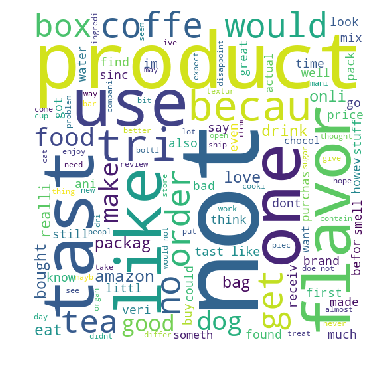

In [36]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white',
                stopwords = stop,
                min_font_size = 10).generate(' '.join(neg_reviews))

plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Postive Reviews Wordcloud

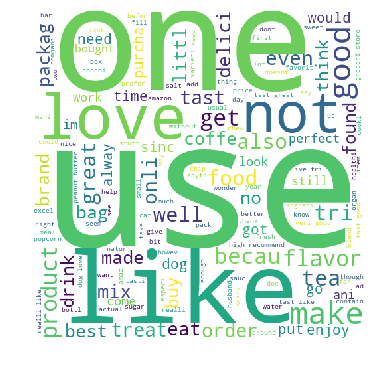

In [37]:
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white',
                stopwords = stop,
                min_font_size = 10).generate(' '.join(pos_reviews))

plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [0]:
from random import shuffle

shuffle(pos_reviews)
shuffle(pos_reviews_w2v)
shuffle(neg_reviews)
shuffle(neg_reviews_w2v)

In [0]:
#choosing 5000 positive and 5000 negative documents

data_subset = np.array(pos_reviews[:5000] + neg_reviews[:5000])
data_subset_w2v = np.array(pos_reviews_w2v[:5000] + neg_reviews_w2v[:5000])
labels = np.hstack((np.ones(5000),np.zeros(5000)))

## **Train-Test Split**

In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_subset, labels, test_size = 0.25, random_state = 42)
#w2v_train, w2v_test, w2v_train, w2v_test = train_test_split(data_subset_w2v, labels, test_size = 0.25, random_state = 42)
x_train = np.array(x_train)
x_test = np.array(x_test)
#w2v_train = np.array(x_train)
#w2v_test = np.array(x_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(7500,) (7500,) (2500,) (2500,)


## **Bag of Words**

### Count Vectorizer

In [41]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(x_train)
print("some feature names ", count_vect.get_feature_names()[90:100])
print('='*50)

x_train_cv = count_vect.transform(x_train)
x_test_cv = count_vect.transform(x_test)
print("the type of count vectorizer ",type(x_train_cv))
print("the shape of out text BOW vectorizer ",x_train_cv.get_shape())
print("the number of unique words ", x_train_cv.get_shape()[1])

some feature names  ['adaptor', 'add', 'addbut', 'adddr', 'addendum', 'addict', 'addictionnot', 'addictit', 'addictiveenjoy', 'addictiveit']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (7500, 13741)
the number of unique words  13741


In [0]:
from collections import Counter

In [43]:
pos_count_vect = CountVectorizer(ngram_range=(1, 3), min_df=0.001) #in scikit-learn
pos_count_vect.fit(pos_reviews)

pos_counts = pos_count_vect.transform(pos_reviews)
print("the type of count vectorizer ",type(pos_counts))
print("the shape of out text BOW vectorizer ",pos_counts.get_shape())
print("the number of unique words ", pos_counts.get_shape()[1])



the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (38480, 4725)
the number of unique words  4725


In [44]:
pos_counts.sum(axis=0)

matrix([[  43, 1006,   58, ...,   73,   44,   75]], dtype=int64)

In [0]:
pos_freqs = zip(pos_count_vect.get_feature_names(), pos_counts.sum(axis=0).tolist()[0])   

In [46]:
pos_bow = sorted(pos_freqs, key=lambda x: -x[1])
pos_bow[:20]

[('like', 14862),
 ('not', 14668),
 ('tast', 13352),
 ('love', 12975),
 ('good', 12363),
 ('great', 11879),
 ('flavor', 11325),
 ('one', 10163),
 ('use', 9829),
 ('veri', 9708),
 ('tri', 9613),
 ('product', 9318),
 ('tea', 8541),
 ('coffe', 8521),
 ('get', 7665),
 ('make', 7620),
 ('food', 7336),
 ('dog', 6426),
 ('buy', 6033),
 ('would', 5932)]

In [47]:
neg_count_vect = CountVectorizer(ngram_range=(1, 3), min_df=0.001) #in scikit-learn
neg_count_vect.fit(neg_reviews)

neg_counts = neg_count_vect.transform(neg_reviews)
print("the type of count vectorizer ",type(neg_counts))
print("the shape of out text BOW vectorizer ",neg_counts.get_shape())
print("the number of unique words ", neg_counts.get_shape()[1])



the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (7592, 5677)
the number of unique words  5677


In [0]:
neg_freqs = zip(neg_count_vect.get_feature_names(), neg_counts.sum(axis=0).tolist()[0])   

In [49]:
neg_bow = sorted(neg_freqs, key=lambda x: -x[1])
neg_bow[:20]

[('not', 5974),
 ('tast', 3927),
 ('like', 3789),
 ('product', 3056),
 ('one', 2262),
 ('tri', 2116),
 ('flavor', 2099),
 ('would', 2094),
 ('veri', 1975),
 ('good', 1686),
 ('buy', 1623),
 ('get', 1599),
 ('use', 1598),
 ('coffe', 1486),
 ('no', 1470),
 ('order', 1465),
 ('food', 1442),
 ('dog', 1395),
 ('dont', 1334),
 ('tea', 1314)]

### TF-IDF Vectorizer

In [50]:
#BoW
tfidf_vect = TfidfVectorizer() #in scikit-learn
tfidf_vect.fit(x_train)
print("some feature names ", tfidf_vect.get_feature_names()[90:100])
print('='*50)

x_train_tfidf = tfidf_vect.transform(x_train)
x_test_tfidf = tfidf_vect.transform(x_test)
print("the type of tf-idf vectorizer ",type(x_train_tfidf))
print("the shape of out text BOW vectorizer ",x_train_tfidf.get_shape())
print("the number of unique words ", x_train_tfidf.get_shape()[1])

some feature names  ['adaptor', 'add', 'addbut', 'adddr', 'addendum', 'addict', 'addictionnot', 'addictit', 'addictiveenjoy', 'addictiveit']
the type of tf-idf vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (7500, 13741)
the number of unique words  13741


In [51]:
pos_tfidf_vect = TfidfVectorizer(ngram_range=(1, 3), min_df=0.001) #in scikit-learn
pos_tfidf_vect.fit(pos_reviews)

pos_tfidfcounts = pos_tfidf_vect.transform(pos_reviews)
print("the type of tfidf vectorizer ",type(pos_counts))
print("the shape of out text BOW vectorizer ",pos_counts.get_shape())
print("the number of unique words ", pos_counts.get_shape()[1])



the type of tfidf vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (38480, 4725)
the number of unique words  4725


In [0]:
pos_tfidf_freqs = zip(pos_tfidf_vect.get_feature_names(), pos_tfidfcounts.sum(axis=0).tolist()[0])   

In [53]:
pos_tfidf_bow = sorted(pos_tfidf_freqs, key=lambda x: -x[1])
pos_tfidf_bow[:20]

[('love', 1010.1341513929426),
 ('like', 974.7664460926215),
 ('great', 972.2820866435143),
 ('tast', 948.6495863730041),
 ('good', 941.6726147834696),
 ('not', 936.9084898750626),
 ('flavor', 860.8814512801781),
 ('tea', 830.6614147113261),
 ('coffe', 829.7410010084388),
 ('product', 801.8358900132368),
 ('veri', 790.03484384124),
 ('use', 757.5749262082841),
 ('one', 750.4815923313072),
 ('tri', 708.9685345325796),
 ('dog', 642.7425235293904),
 ('make', 622.2262525308483),
 ('get', 618.3914179798771),
 ('food', 604.738555015042),
 ('buy', 577.9702946966459),
 ('best', 552.9535225966899)]

In [54]:
neg_tfidf_vect = TfidfVectorizer(ngram_range=(1, 3), min_df=0.001) #in scikit-learn
neg_tfidf_vect.fit(neg_reviews)

neg_tfidfcounts = neg_tfidf_vect.transform(neg_reviews)
print("the type of tfidf vectorizer ",type(neg_counts))
print("the shape of out text BOW vectorizer ",neg_counts.get_shape())
print("the number of unique words ", neg_counts.get_shape()[1])



the type of tfidf vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (7592, 5677)
the number of unique words  5677


In [0]:
neg_tfidf_freqs = zip(neg_tfidf_vect.get_feature_names(), neg_tfidfcounts.sum(axis=0).tolist()[0])   

In [56]:
neg_tfidf_bow = sorted(neg_tfidf_freqs, key=lambda x: -x[1])
neg_tfidf_bow[:20]

[('not', 284.849989240274),
 ('tast', 231.3735855857002),
 ('like', 213.9395242562294),
 ('product', 196.9003791207406),
 ('flavor', 154.1409866976356),
 ('one', 145.99473233243066),
 ('veri', 142.51585455071333),
 ('tri', 139.92505433407007),
 ('would', 138.01918637132908),
 ('coffe', 136.24913384590687),
 ('buy', 129.17099142967203),
 ('good', 124.61305225770487),
 ('order', 124.3819757659809),
 ('tea', 121.76681242320717),
 ('dog', 119.52784419683708),
 ('get', 118.67818930835806),
 ('use', 116.53620445183445),
 ('no', 110.20855386494073),
 ('food', 109.28854393868741),
 ('dont', 107.73948340356314)]

### Word2Vec

In [57]:
w2v_model=Word2Vec(w2v_doc,window=10,min_count=10,size=50, workers=4)
print(w2v_model.wv.most_similar('good'))
print('='*50)
print(w2v_model.wv.most_similar('bad'))

[('great', 0.7679034471511841), ('fantastic', 0.7565938830375671), ('decent', 0.7433007955551147), ('amazing', 0.727970540523529), ('awesome', 0.6864615678787231), ('nice', 0.6672049760818481), ('terrific', 0.6448011994361877), ('tasty', 0.6405789256095886), ('wonderful', 0.6214460134506226), ('bad', 0.6092713475227356)]
[('ok', 0.7170208692550659), ('terrible', 0.7052658796310425), ('funny', 0.6912538409233093), ('awful', 0.673064649105072), ('okay', 0.6607506275177002), ('horrible', 0.6607315540313721), ('disgusting', 0.6577566862106323), ('gross', 0.6423328518867493), ('nasty', 0.6404697895050049), ('weird', 0.6377608776092529)]


In [58]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[60:100])

number of words that occured minimum 5 times  7921
sample words  ['been', 'around', 'few', 'light', 'citrus', 'gelatin', 'with', 'nuts', 'in', 'case', 'cut', 'into', 'tiny', 'squares', 'then', 'liberally', 'coated', 'powdered', 'sugar', 'mouthful', 'heaven', 'too', 'chewy', 'very', 'flavorful', 'highly', 'recommend', 'yummy', 'treat', 'you', 'are', 'familiar', 'story', 'cs', 'selling', 'out', 'his', 'brother', 'sisters', 'looking']


In [59]:
print(w2v_model.wv.most_similar('not'))

[('trick', 0.5364296436309814), ('perhaps', 0.5004056096076965), ('neither', 0.4713261127471924), ('suppose', 0.4696781635284424), ('isnt', 0.46910202503204346), ('nothing', 0.4664407968521118), ('maybe', 0.455588698387146), ('yes', 0.4513782858848572), ('though', 0.4290004372596741), ('doesnt', 0.4226720631122589)]


**Avg W2V** (for 5000 documents only)

In [60]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(data_subset_w2v): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 10000/10000 [00:17<00:00, 573.90it/s]

10000
50


In [0]:
x_train_w2v_av, x_test_w2v_av, y_train, y_test = train_test_split(sent_vectors, labels, test_size = 0.25, random_state = 42)

**TFIDF weighted W2V** (for 5000 documents only)

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews[:5000])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [63]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(data_subset_w2v): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 10000/10000 [01:57<00:00, 79.81it/s]


In [0]:
x_train_w2v_tf, x_test_w2v_tf, y_train, y_test = train_test_split(tfidf_sent_vectors, labels, test_size = 0.25, random_state = 42)

## tSNE visualization on the different BOWs

### 1) Count Vectorizer

In [0]:
from sklearn.manifold import TSNE

x = final_counts.todense()[:5000]
y = np.array(filtered_data['Score'][:5000])

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding_cv = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix



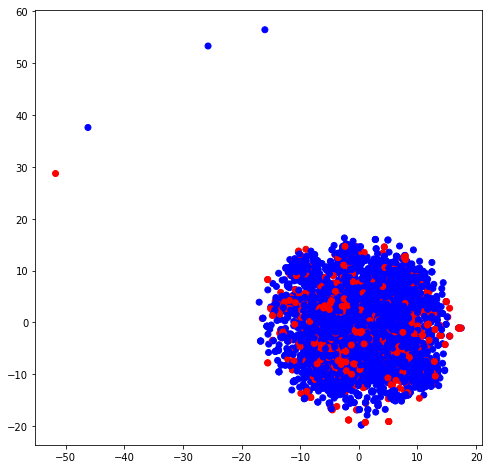

In [0]:
for_tsne = np.hstack((X_embedding_cv, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue'}
plt.figure(figsize = (8, 8) )
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

### 2) Tf-IDF Vectorizer

In [0]:
from sklearn.manifold import TSNE

x = tffinal_counts.todense()
y = np.array(filtered_data['Score'][:5000])

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding_tfidf = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix



In [0]:
X_embedding_tfidf.shape

(5000, 2)

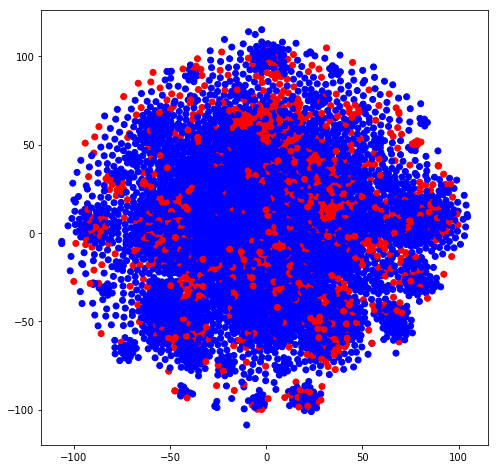

In [0]:
for_tsne = np.hstack((X_embedding_tfidf, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue'}
plt.figure(figsize = (8, 8) )
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

### 3) Avg W2v

In [0]:
from sklearn.manifold import TSNE

x = np.array(sent_vectors)
y = np.array(filtered_data['Score'][:5000])

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding_avgw2v = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix



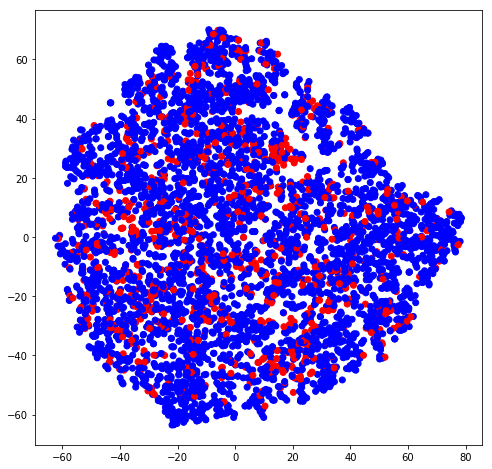

In [0]:
for_tsne = np.hstack((X_embedding_avgw2v, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue'}
plt.figure(figsize = (8, 8) )
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

### 4) TfIdf wieghted W2v

In [0]:
from sklearn.manifold import TSNE

x = np.array(tfidf_sent_vectors)
y = np.array(filtered_data['Score'][:5000])

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding_tfidfw2v = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix



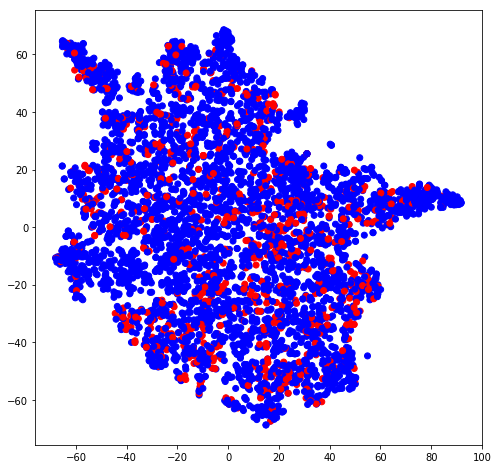

In [0]:
for_tsne = np.hstack((X_embedding_tfidfw2v, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue'}
plt.figure(figsize = (8, 8) )
a = plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]) )
plt.show()

In [0]:
np.save('x_train_cv.npy',x_train_cv.todense())
np.save('x_test_cv.npy',x_test_cv.todense())
np.save('x_train_tfidf.npy',x_train_tfidf.todense())
np.save('x_test_tfidf.npy',x_test_tfidf.todense())
np.save('x_train_w2v_av.npy',x_train_w2v_av)
np.save('x_test_w2v_av.npy',x_test_w2v_av)
np.save('x_train_w2v_tf.npy',x_train_w2v_tf)
np.save('x_test_w2v_tf.npy',x_test_w2v_tf)
np.save('y_train.npy',y_train)
np.save('y_test.npy',y_test)

In [68]:
np.unique(y_train,return_counts=True)

(array([0., 1.]), array([3772, 3728]))

In [69]:
np.unique(y_test,return_counts=True)

(array([0., 1.]), array([1228, 1272]))